### Defensive Asset Allocation with momentum
Use Index of representative asset classes. Market Index ETF, sector etf, bond etf are included   
Result is driven from 2010 to 2021 market data   

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
import quantstats

In [4]:
start_date='2006-01-01'
end_date='2022-10-01'
cost=0.001

In [5]:
custom_universe =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "EFA",  # iShares MSCI EAFE ETF                                 2001-08-02
    "EEM",  # iShares MSCI Emerging Markets ETF                     2003-04-07
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEF",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22

    # Canaria Assets
    "EEM",  # iShares MSCI Emerging Markets ETF                     2003-04-07
    "IEF"  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    
    ]

In [6]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [7]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [8]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation

[__init__] is executed in 3.49 seconds
[__init__] is executed in 4.64 seconds


In [9]:
class DAA(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series

        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)

        target = {} 
        
        result = self.daa_momentum(return_df)
        for ticker in return_df.columns:
            target[ticker] = result.loc[date, ticker]

        return target


    def get_momentum(self, yld_df):
        """
        calculate momentum of sectors. use 12 month, 6 month, 3 month momentum to bit market
        input
        yiled_df : dataframe with weekly yield of asset classes

        returns : momentum in pandas dataframe format. momentum of each asset classes for give date
        """
        momentum = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        
        windows = 250
        for ticker in yld_df.columns:
            i = 0 
            for date in yld_df.index:
                # 250 days before = 1 year  before
                if i > windows :
                    # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                    momentum.loc[date, ticker] = yld_df[ticker].iloc[i] / yld_df[ticker].iloc[i - windows] - 1
                    
                    current = yld_df[ticker].iloc[i]
                    before_1m = yld_df[ticker].iloc[i-20]
                    before_3m = yld_df[ticker].iloc[i-60]
                    before_6m = yld_df[ticker].iloc[i-120]
                    before_12m = yld_df[ticker].iloc[i-250]

                    momentum.loc[date, ticker] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                                + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
                
                else:
                    momentum.loc[date, ticker] = 0
                i = i + 1

        momentum = momentum.replace([np.inf], 1000)
        momentum = momentum.replace([-np.inf], -1000)
        momentum = momentum.replace([np.nan], 0)
        return momentum

    def select_sector(self, yld_df):
        """
        select top scored two offensive sectors if condition satisfied(canaria not dead).
        If failed to save canaria, escape to Defensive strategy.

        Criteria: if any of canaria asset classes show negative momentum score, escape to canaria assets.

        returns: selected_tickers in list format. list with top 5 momentum in given period`
        """
        momentum_df = self.get_momentum(yld_df)

        selected_momentum = pd.DataFrame(
            columns=['momentum_1','momentum_2'],
            index=momentum_df.index
        )
        selected_ticker = pd.DataFrame(
            columns=['momentum_1','momentum_2'],
            index=momentum_df.index
        )

        selectable_asset = [
        "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
        "EFA",  # iShares MSCI EAFE ETF                                 2001-08-02
        "EEM",  # iShares MSCI Emerging Markets ETF                     2003-04-07
        "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
        "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
        "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
        ]
        # print("emerging market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['EEM'] >= 0]['EEM'].count())
        # print("negative signal : ", momentum_df[momentum_df['EEM'] < 0]['EEM'].count())


        # print("bond market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['TLT'] >= 0]['TLT'].count())
        # print("negative signal : ", momentum_df[momentum_df['TLT'] < 0]['TLT'].count())


        for date in momentum_df.index:
            emerging_momentum = momentum_df.loc[date,'EEM']
            bond_momentum = momentum_df.loc[date,'IEF']

            short_treasury_momentum = momentum_df.loc[date,'SHY']
            mid_treasury_momentum = momentum_df.loc[date,'IEF']

            sorted_momentum = momentum_df[selectable_asset].loc[date].sort_values(ascending=False)

            if emerging_momentum >= 0 and bond_momentum >= 0:
                selected_momentum.loc[date,'momentum_1'] = sorted_momentum[0]
                selected_ticker.loc[date,'momentum_1'] = sorted_momentum.index[0]

                selected_momentum.loc[date,'momentum_2'] = sorted_momentum[1]
                selected_ticker.loc[date,'momentum_2'] = sorted_momentum.index[1]

            else:
                selected_momentum.loc[date,'momentum_1'] = short_treasury_momentum
                selected_ticker.loc[date,'momentum_1'] = 'SHY'

                selected_momentum.loc[date,'momentum_2'] = mid_treasury_momentum
                selected_ticker.loc[date,'momentum_2'] = 'IEF'

        return selected_ticker

    def daa_momentum(self, yld_df):
        """
        returns : market portfolio in pandas dataframe format.
        """
        mom_ticker_df = self.select_sector(yld_df)
        mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        for date in mom_ticker_df.index:
            selected = mom_ticker_df.loc[date].tolist()
            for sel in selected:
                mp_table.loc[date, sel] = 1/2
        mp_table = mp_table.fillna(0)
        return mp_table

In [10]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
vaa = DAA(engine.cache)
engine.run_backtest(target_generator=vaa, sdate=start_date, edate=end_date, transaction_cost=cost)
myasset = engine.asset_df.sum(axis=1)
myasset

[__init__] is executed in 7.01 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-30 00:00:00
=== date:2022-09-30 00:00:00 / total_asset:2.325 / time elapsed:126.7 ===
[run_backtest] is executed in 127.53 seconds


2006-01-03    0.999000
2006-01-04    1.000391
2006-01-05    1.000075
2006-01-06    0.999544
2006-01-09    0.999844
                ...   
2022-09-26    2.313261
2022-09-27    2.305504
2022-09-28    2.336006
2022-09-29    2.329038
2022-09-30    2.325038
Length: 4216, dtype: float64

In [12]:
bm_engine = BacktestEngine(yfinance_list=['IVV','AGG'])
_60_40_portfolio = _60_40_allocation(bm_engine.cache)
bm_engine.run_backtest(target_generator=_60_40_portfolio, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark1 = bm_engine.asset_df.sum(axis=1)
benchmark1

[__init__] is executed in 4.08 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-30 00:00:00
=== date:2022-09-30 00:00:00 / total_asset:2.908 / time elapsed:4.7 ===
[run_backtest] is executed in 4.89 seconds


2006-01-03    0.999000
2006-01-04    1.003072
2006-01-05    1.003545
2006-01-06    1.007641
2006-01-09    1.009638
                ...   
2022-09-26    2.937541
2022-09-27    2.927946
2022-09-28    2.980869
2022-09-29    2.938194
2022-09-30    2.908181
Length: 4216, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-09-30  2022-09-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          132.74%     191.11%
CAGR﹪                     5.17%       6.59%

Sharpe                     0.61        0.6
Prob. Sharpe Ratio         99.31%      99.28%
Smart Sharpe               0.59        0.58
Sortino                    0.88        0.84
Smart Sortino              0.86        0.81
Sortino/√2                 0.63        0.59
Smart Sortino/√2           0.61        0.58
Omega                      1.18        1.18

Max Drawdown               -25.35%     -35.47%
Longest DD Days            935         1121
Volatility (ann.)          8.93%       11.74%
R^2                        0.04        0.04
Information Ratio          -0.01       -0.01
Calmar                     0.2       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2022-09-27,2022-09-30,935,-25.348092,-23.864848
2,2011-11-09,2011-11-25,2013-01-22,440,-11.609122,-8.852227
3,2008-01-04,2008-01-22,2008-11-20,321,-10.182611,-8.376403
4,2013-05-22,2013-06-24,2013-08-01,71,-7.910378,-6.874354
5,2009-04-20,2009-04-20,2009-04-24,4,-7.820522,-4.863035


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


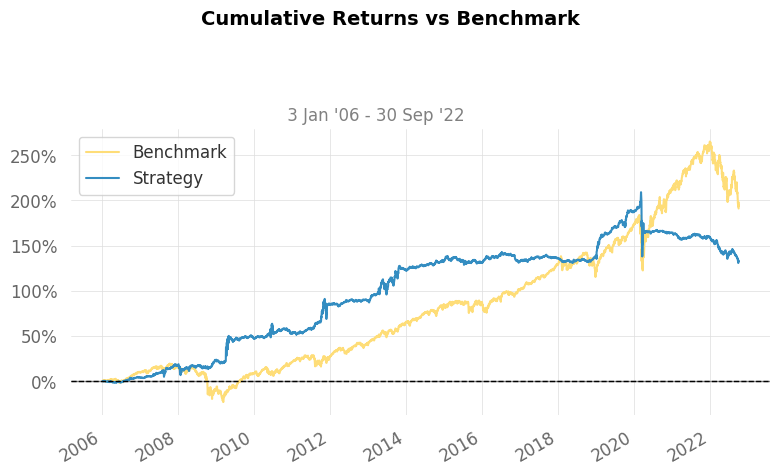

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


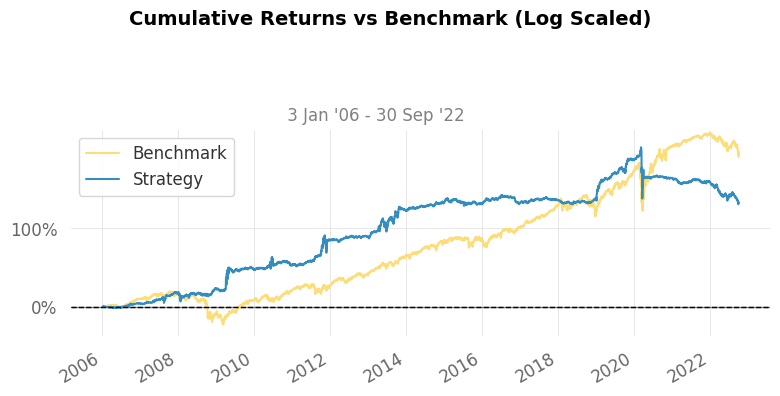

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


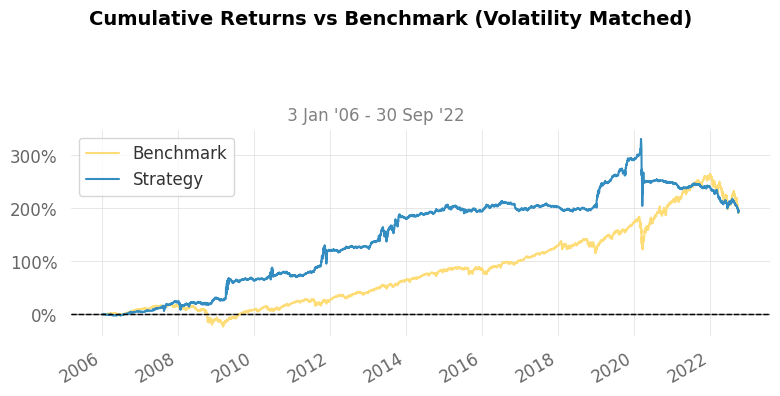

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


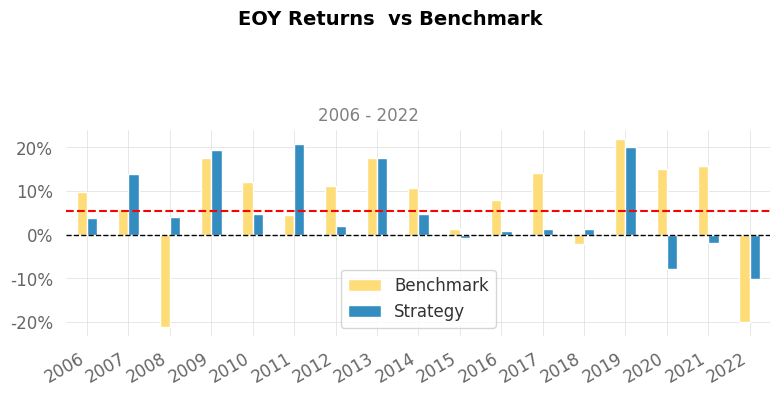

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


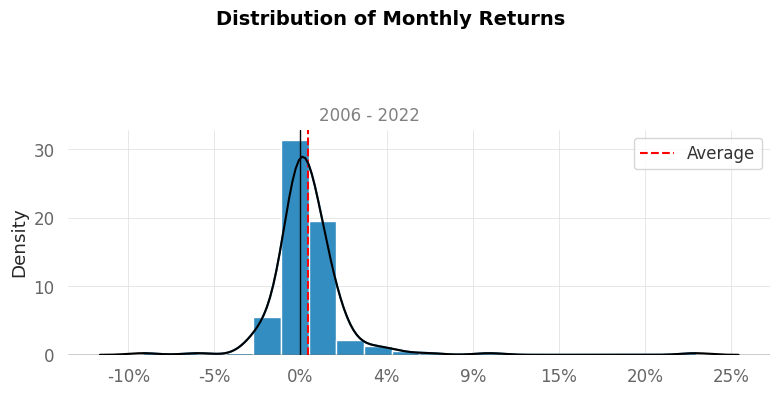

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


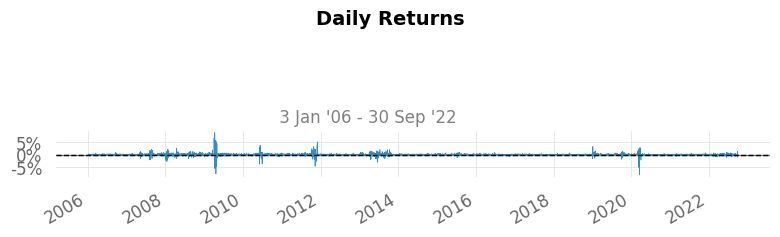

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


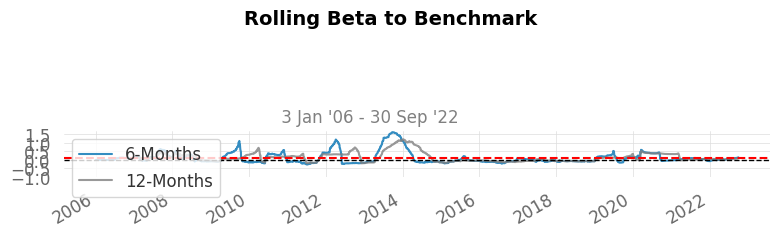

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


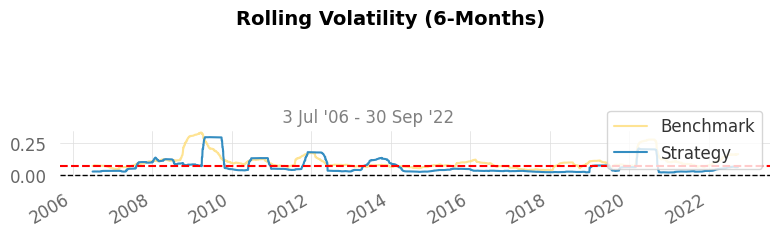

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


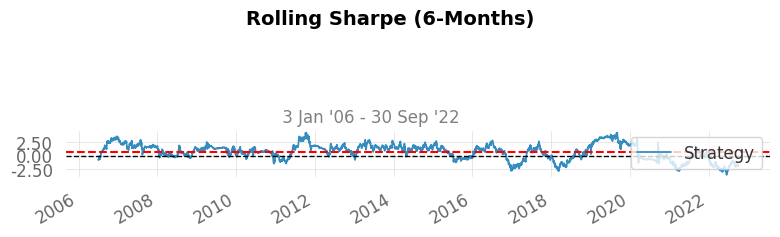

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


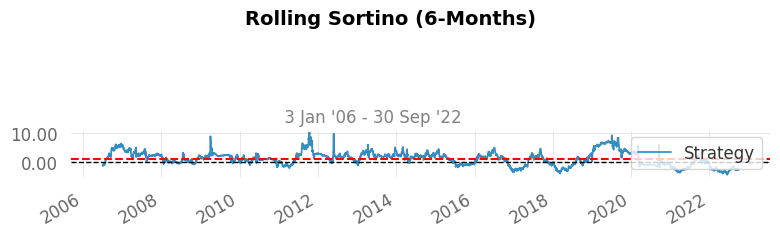

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


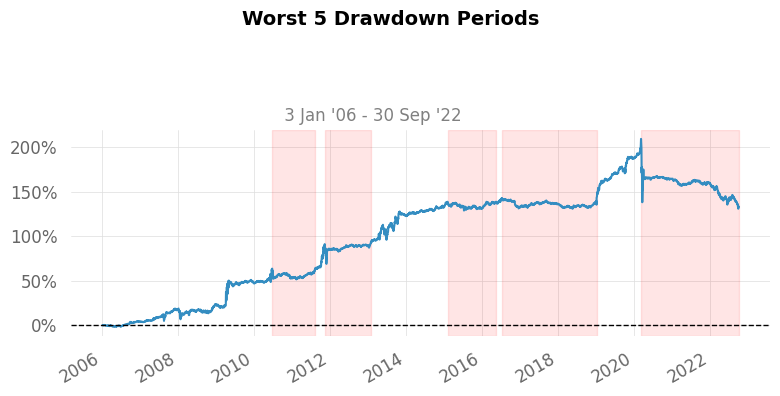

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


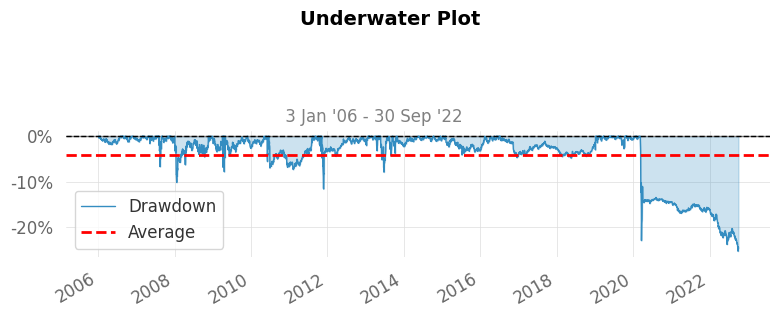

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


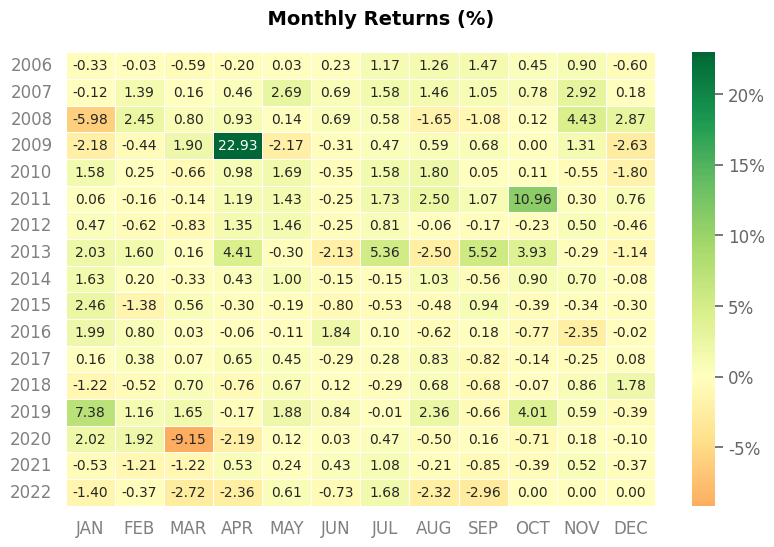

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


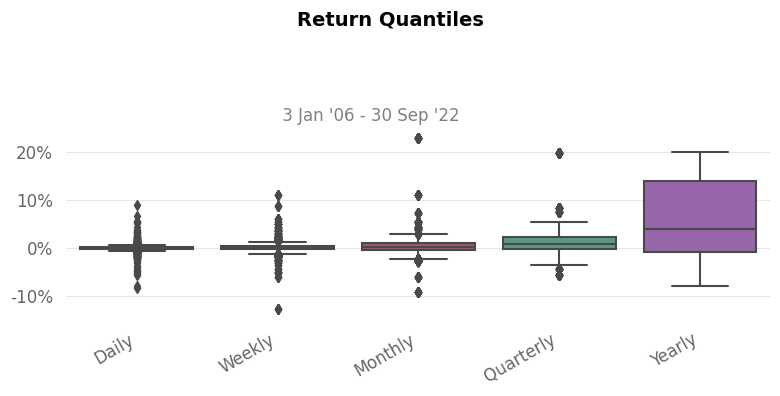

In [13]:
quantstats.reports.full(returns=myasset, benchmark=benchmark1)

In [ ]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,EFA,TLT,SHY,RWR,IVV,SPY,LQD,EEM,IEF,BND
2006-01-03,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2006-01-04,0.0,0.0,0.0,0.499802,0.0,0.0,0.0,0.0,0.0,0.500198,0.0
2006-01-05,0.0,0.0,0.0,0.499525,0.0,0.0,0.0,0.0,0.0,0.500475,0.0
2006-01-06,0.0,0.0,0.0,0.499915,0.0,0.0,0.0,0.0,0.0,0.500085,0.0
2006-01-09,0.0,0.0,0.0,0.499827,0.0,0.0,0.0,0.0,0.0,0.500173,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.0,0.0,0.0,0.508836,0.0,0.0,0.0,0.0,0.0,0.491164,0.0
2022-09-27,0.0,0.0,0.0,0.510548,0.0,0.0,0.0,0.0,0.0,0.489452,0.0
2022-09-28,0.0,0.0,0.0,0.506058,0.0,0.0,0.0,0.0,0.0,0.493942,0.0
2022-09-29,0.0,0.0,0.0,0.506886,0.0,0.0,0.0,0.0,0.0,0.493114,0.0


<AxesSubplot: >

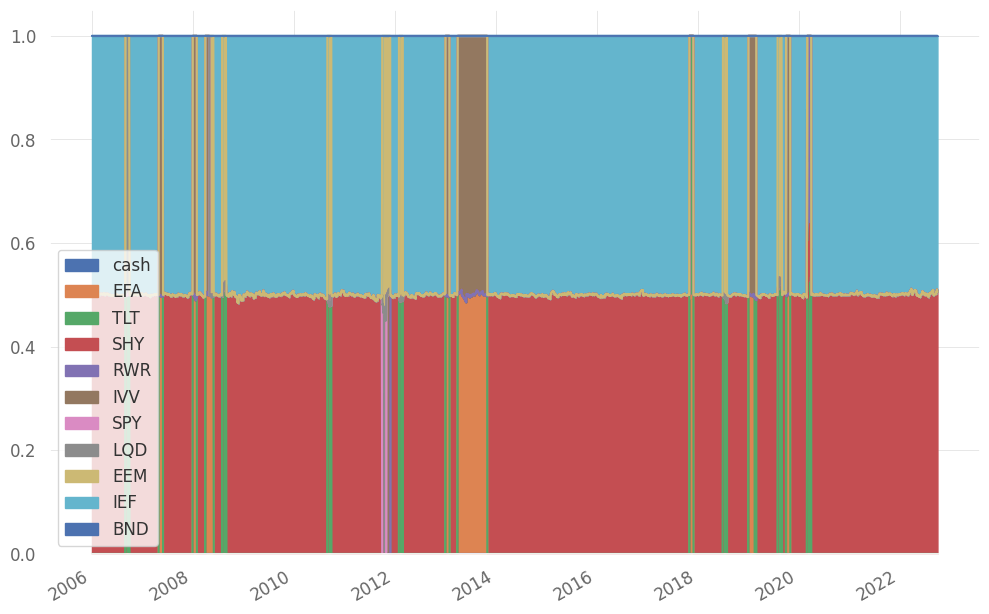

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()

#### Why this strategy doesn't work after COVID-19 (2020)
AS shown above, bond market showed steady decline from COVID_19.   
In addition, emerging stock market showed dramatic decline from 2021.   
Thus canaria would prevent from investing risky assets.  

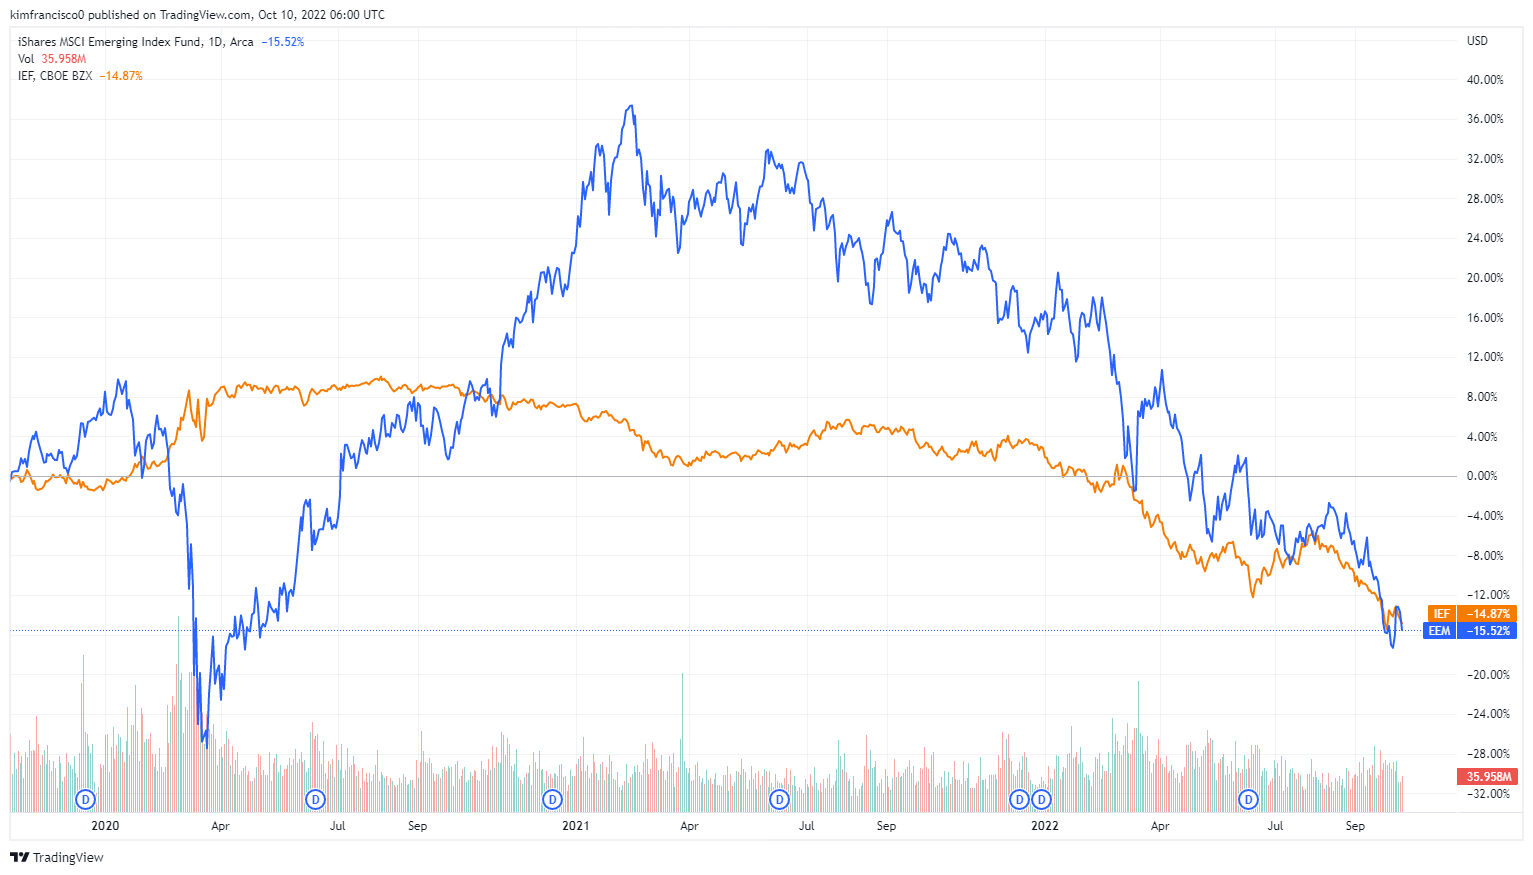

In [17]:
from IPython.display import Image
Image('asset/image/EEM_2022-10-10_15-00-53.png')

AS shown above, bond market showed steady decline from COVID_19. In addition, emerging stock market showed dramatic decline from 2021. Thus canaria would prevent from investing risky assets.